## Classification of the Palmer penguins data

This document is part of the showcase, where I replicate the same brief and simple analyses with different tools.

This particular file focuses on simple classification of the Palmer penguins data from the tidytuesday project.

The data can be found in <https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-28>. They consist of one documents: *penguins.csv* contains information and measurements about some penguins.

For the specific analysis I will use **Python** and **scikit-learn** (plus **Jupyter notebook**).

We start by loading the packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

and the dataset:

In [2]:
penguins = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-28/penguins.csv')

We can have a look at the schema of the data:

In [3]:
penguins.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


and the summary statistics:

In [4]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Our main goal is to try and build a model that classifies the species of the penguins based on their other characteristics.

We start by checking for missing values:

<AxesSubplot:>

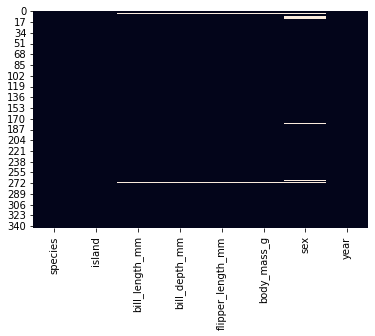

In [5]:
sns.heatmap(penguins.isnull(), cbar=False)

In [6]:
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

The plot shows that 5 of the features contain missing data (11 regard sex and 2 for each of the penguin measurements). In addition there are 2 penguins for which we have neither sex information nor the measurements, and 9 additional penguins for which we are only missing the sex.

In practice, since this is a small amount of missing data we could drop all of them, but for the purposes of this showcase, we are going to drop only those that are missing the majority of information and impute the ones that are missing only the sex (later).

In [7]:
penguins = penguins.dropna(axis = 0, thresh=4, how = "all")
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
year                 0
dtype: int64

Now we can plot the classes:

<AxesSubplot:>

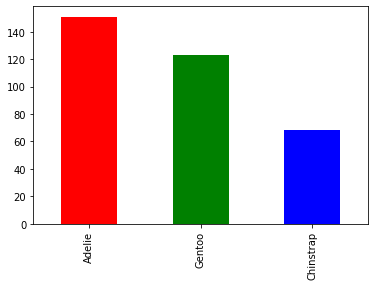

In [8]:
penguins['species'].value_counts().plot.bar(color=['red', 'green', 'blue'])

This is not very bad for a small and simple dataset like this, but once again for this showcase we are going to try and balance the classes (later).

We can also plot the scatterplots, conditional distributions and boxplots and also check the individual correlations (for the continuous features).

We exclude the year each penguin was recorded.

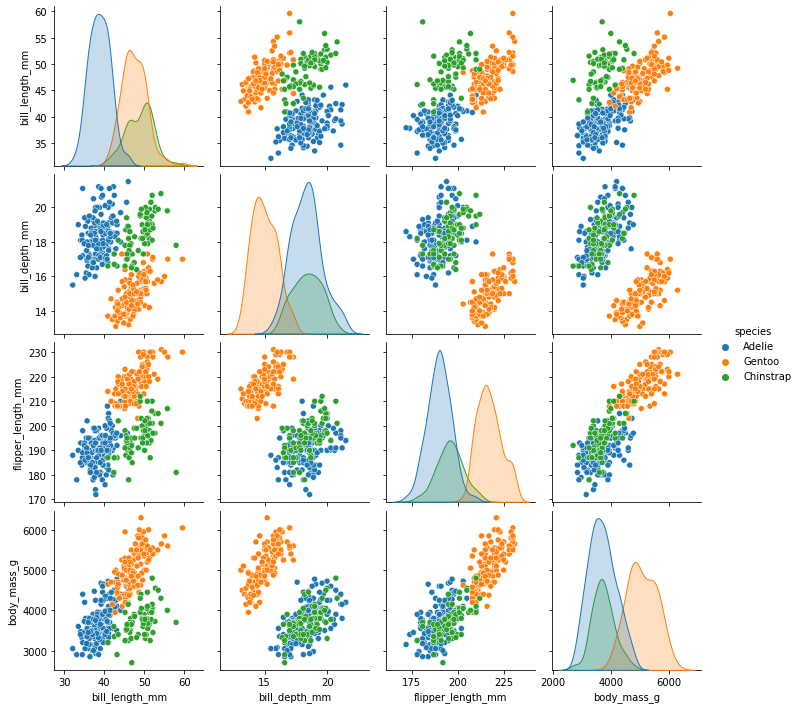

In [9]:
penguins = penguins.drop(columns='year')
sns.pairplot(penguins, hue="species")

There are some pretty clear patterns patterns, so we are going to use all the features.

First, we are going to split the data into features and label:

In [10]:
species = penguins.pop('species')

Now we can split the dataset to training and testing:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(penguins, species, test_size=0.2, random_state=1, stratify=species)

The first model we are going to use is a support vector machine. We define the model and the pre-processing steps:
* Switch all nominal predictors to one-hot encoding
* k nearest neighbor imputation for the sex feature
* Normalize all numeric predictors
* Apply the classifier

In [12]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pipe_svc = Pipeline([ ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)), ('imputer', KNNImputer(n_neighbors=2, weights="uniform")), ('scaler', StandardScaler(with_mean=False)), ('svc', svm.SVC())])

We fit the training data into the pipeline:

In [13]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', StandardScaler(with_mean=False)), ('svc', SVC())])

We can check the predictions of the testing data:

In [14]:
pipe_svc.score(X_test, y_test)

0.8115942028985508

And finally, we can check some metrics:

In [15]:
from sklearn.metrics import classification_report

y_pred_svc = pipe_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

      Adelie       0.70      1.00      0.82        30
   Chinstrap       1.00      0.07      0.13        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.81        69
   macro avg       0.90      0.69      0.65        69
weighted avg       0.87      0.81      0.75        69



We are also going to fit a simple decision tree model. We specify a new pipeline with the new algorithm and the same pre-processing steps:

In [16]:
from sklearn import tree
pipe_tree = Pipeline([ ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)), ('imputer', KNNImputer(n_neighbors=2, weights="uniform")), ('scaler', StandardScaler(with_mean=False)), ('dec_tree', tree.DecisionTreeClassifier())])

And fit on the training data data:

In [17]:
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', StandardScaler(with_mean=False)),
                ('dec_tree', DecisionTreeClassifier())])

And once again test on the testing data:

In [18]:
pipe_tree.score(X_test, y_test)

0.7536231884057971

And check on the metrics:

In [19]:
y_pred_tree = pipe_tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

      Adelie       0.84      0.53      0.65        30
   Chinstrap       0.61      0.79      0.69        14
      Gentoo       0.78      1.00      0.88        25

    accuracy                           0.75        69
   macro avg       0.74      0.77      0.74        69
weighted avg       0.77      0.75      0.74        69



In most aspects the support vector machine classifier performed significantly better, though it struggled with classifying the Chinstrap penguins.